In [1]:
import os
import json

import numpy as np
import pandas as pd
import pennylane as qml

In [37]:
folder_path = r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\qml.Sample\ADAPT-VQE\Files\DW"
file_paths = os.listdir(folder_path)

In [38]:
json_files = [f for f in file_paths if f.endswith('.json')]
json_files

['DW_2.json', 'DW_4.json', 'DW_8.json']

########################################################################
Finding optimal circuit for DW - cutoff 2
Exact eigenvalue: 0.35723304703363135
Closest energy: 0.35723304703363123
Energy list for best circuit: [0.35723304703363123, 0.3627413854005925, 0.3574290268310957, 0.3635627353300805, 0.3572371891692549, 0.3599925924765818, 0.35723304703363123]
Gates needed to reach best energy: 1
Gate sequence: [{'name': 'RY', 'param': 5.911759535512584, 'wires': [1]}, {'name': 'CRY', 'param': 2.5755603541700305, 'wires': [1, 0]}, {'name': 'RY', 'param': 2.9293143080488457, 'wires': [0]}, {'name': 'RY', 'param': 1.101974295701929, 'wires': [1]}, {'name': 'CRY', 'param': 2.186344154195564, 'wires': [0, 1]}, {'name': 'RY', 'param': 1.5655240883020565, 'wires': [1]}, {'name': 'RY', 'param': 3.550873335787061, 'wires': [0]}]
########################################################################
Finding optimal circuit for DW - cutoff 4
Exact eigenvalue: 0.9065598714743818
Closest energy: 

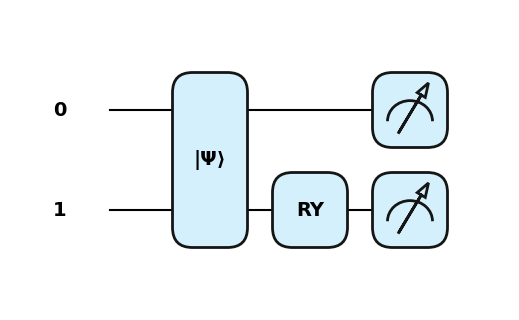

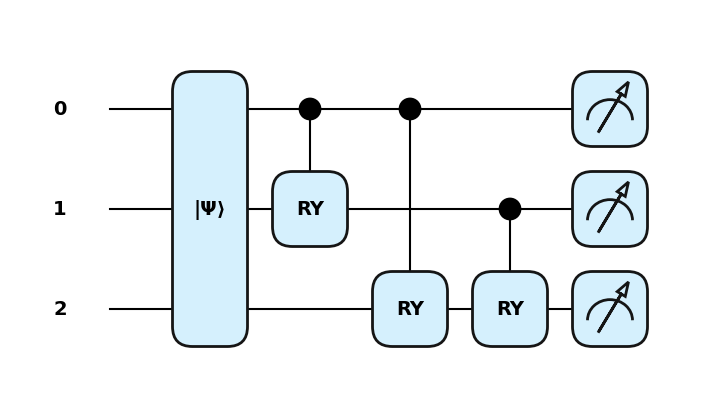

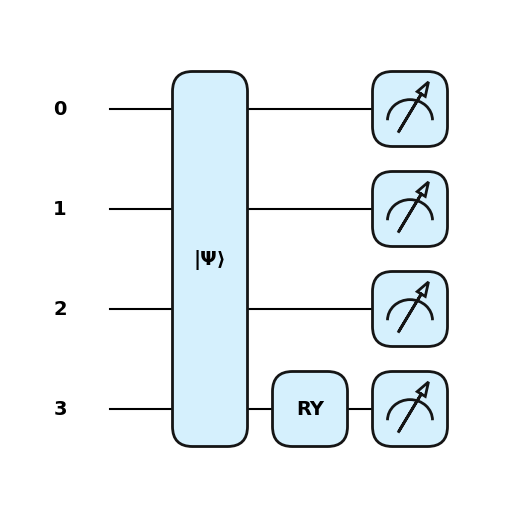

In [39]:
for file in json_files:
    
    data_path = os.path.join(folder_path,file)
    data_dict = {}

    with open(data_path, 'r') as file:
            data = json.load(file)

    cutoff = data['cutoff']
    potential = data['potential']
    energies = data['all_energies']

    print("########################################################################")
    print(f"Finding optimal circuit for {potential} - cutoff {cutoff}")

    num_qubits = int(np.log2(cutoff)) + 1
    min_eigenvalue = min(data['exact_eigenvalues'])

    closest_e = np.inf
    best_index = 0
    gate_length = np.inf
    best_energy_value = None
    best_gate_position = None

    for i, e1 in enumerate(energies):
        for g_idx, e2 in enumerate(e1, start=1):  # gate count = index
            ediff = abs(e2 - min_eigenvalue)

            # if closer OR equal but with fewer gates
            if ediff < closest_e or (ediff == closest_e and g_idx < gate_length):
                closest_e = ediff
                best_index = i
                gate_length = g_idx
                best_energy_value = e2
                best_gate_position = g_idx

    best_gate_set = data['op_list'][best_index]
    best_energy_list = energies[best_index]

    print(f"Exact eigenvalue: {min_eigenvalue}")
    print(f"Closest energy: {best_energy_value}")
    print(f"Energy list for best circuit: {best_energy_list}")
    print(f"Gates needed to reach best energy: {best_gate_position}")
    print(f"Gate sequence: {best_gate_set}")


    basis_state = data["basis_state"]
    best_circuit = best_gate_set[:best_gate_position]

    data_dict = {}
    data_dict['potential'] = potential
    data_dict['cutoff'] = cutoff
    data_dict['basis_state'] = basis_state
    data_dict['circuit'] = best_circuit

    file_path = os.path.join(folder_path, f"data_{cutoff}.txt")

    with open(file_path, "w") as file:
        json.dump(data_dict, file, indent=4)

    # Define the device
    dev = qml.device("default.qubit", wires=num_qubits)


    @qml.qnode(dev)
    def circuit():

        qml.BasisState(basis_state, wires=range(num_qubits))

        for op_dict in best_circuit:
            op = getattr(qml, op_dict["name"])
            op(op_dict['param'], wires=op_dict['wires'])

        return qml.state()

    circuit_diagram = qml.draw(circuit)()
    mpl_diagram, ax = qml.draw_mpl(circuit, style='pennylane')()

    diagram_path = os.path.join(folder_path, "circuitDiagrams")
    os.makedirs(diagram_path, exist_ok=True)
    mpl_diagram.savefig(diagram_path + f"\\{potential}_{cutoff}.png")


    with open(file_path, "a", encoding="utf-8") as file:
        file.write("\n###############################\n")
        file.write(circuit_diagram)
        file.write("\n###############################\n")


In [30]:
best_gate_set[:best_gate_position]

[{'name': 'CRY', 'param': 5.617091502523945, 'wires': [0, 1]},
 {'name': 'RY', 'param': 1.4601939139922784, 'wires': [1]},
 {'name': 'RY', 'param': 2.124324436614301, 'wires': [2]}]

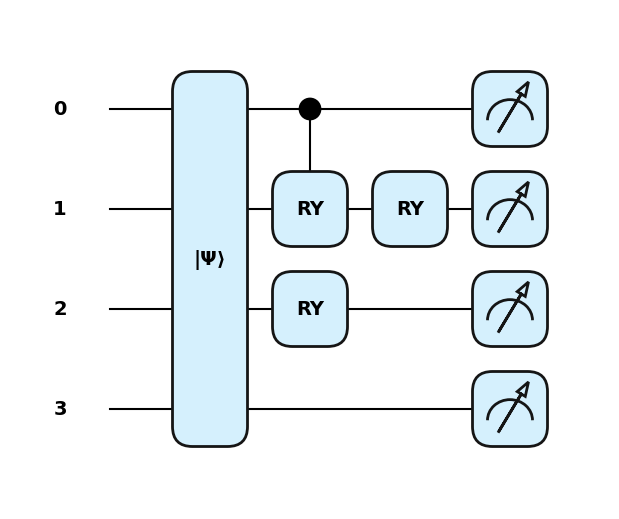

In [32]:
basis_state = data["basis_state"]
best_circuit = best_gate_set[:best_gate_position]

data_dict = {}
data_dict['potential'] = potential
data_dict['cutoff'] = cutoff
data_dict['basis_state'] = basis_state
data_dict['circuit'] = best_circuit

file_path = os.path.join(folder_path, f"data_{cutoff}.txt")

with open(file_path, "w") as file:
    json.dump(data_dict, file, indent=4)

# Define the device
dev = qml.device("default.qubit", wires=num_qubits)


@qml.qnode(dev)
def circuit():

    qml.BasisState(basis_state, wires=range(num_qubits))

    for op_dict in best_circuit:
        op = getattr(qml, op_dict["name"])
        op(op_dict['param'], wires=op_dict['wires'])

    return qml.state()

circuit_diagram = qml.draw(circuit)()
mpl_diagram, ax = qml.draw_mpl(circuit, style='pennylane')()

diagram_path = os.path.join(folder_path, "circuitDiagrams")
os.makedirs(diagram_path, exist_ok=True)
mpl_diagram.savefig(diagram_path + f"\\{potential}_{cutoff}.png")


with open(file_path, "a", encoding="utf-8") as file:
    file.write("\n###############################\n")
    file.write(circuit_diagram)
    file.write("\n###############################\n")


In [3]:
potentials = ['QHO','AHO', 'DW']
cutoffs = [2,4,8,16,32]

d_potentials = []
d_cutoffs = []
d_basis = []
d_ops_list = []
d_exact_e = []
d_energies = []


for potential in potentials:
    for cutoff in cutoffs:
        data_path = os.path.join(r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\ADAPT-VQE\Files100Runs", potential, f"{potential}_{cutoff}.json")

        with open(data_path, 'r') as file:
            data = json.load(file)

        min_eigenvalue = min(data['exact_eigenvalues'])


        d_potentials.append(potential)
        d_cutoffs.append(cutoff)
        d_basis.append(data['basis_state'])
        d_exact_e.append(min_eigenvalue)

        # Only consider data that has converge to min energy
        mask = []
        for d in data['min_energies']:
            if abs(d - min_eigenvalue) < 1e-6:
                mask.append(True)
            else:
                mask.append(False)

        # Clean and prepare circuit data
        min_ops = [op_list for op_list, keep in zip(data['op_list'], mask) if keep]
        min_len = min([len(ops) for ops in min_ops])
        reduced = [ops for ops in min_ops if len(ops) == min_len]
        energies = [min(op_list) for op_list, keep in zip(data['all_energies'], mask) if keep]

        d_energies.append(min(energies))


        # Take the unique circuits
        unique_set = set()
        unique_op_lists = []

        for ops in reduced:
            
            set_key = tuple((op['name'], tuple(op['wires'])) for op in ops)
            
            if set_key not in unique_set:
                unique_set.add(set_key)
                unique_op_lists.append(ops)

        all_labels = []
        for i in range(len(unique_op_lists)):
            op_labels = []

            for op_dict in unique_op_lists[i]:
            
                wires = op_dict['wires']
                if len(wires) > 1:
                    label = f'{op_dict['name']}({str(wires[0])},{str(wires[1])})'
                else:
                    label = f"{op_dict['name']}({str(wires[0])})"

                op_labels.append(label)

            all_labels.append(op_labels)

        d_ops_list.append(all_labels)
    

In [4]:
data_dict = {'Potential':d_potentials,
      'Cutoff': d_cutoffs,
      'Basis State': d_basis,
      'Operators': d_ops_list,
      'Min E Exact': d_exact_e,
      'Min E': d_energies}

In [5]:
df = pd.DataFrame(data_dict)
df

,Potential,Cutoff,Basis State,Operators,Min E Exact,Min E
0,QHO,2,"[1, 0]",[[RY(0)]],0.000000,0.000000
1,QHO,4,"[1, 0, 0]",[[RY(0)]],0.000000,0.000000
2,QHO,8,"[1, 0, 0, 0]",[[RY(0)]],0.000000,0.000000
3,QHO,16,"[1, 0, 0, 0, 0]",[[RY(0)]],0.000000,0.000000
4,QHO,32,"[1, 0, 0, 0, 0, 0]",[[RY(0)]],0.000000,0.000000
5,AHO,2,"[1, 0]",[[RY(0)]],-0.437500,-0.437500
6,AHO,4,"[1, 0, 0]",[[RY(1)]],-0.164785,-0.164785
7,AHO,8,"[1, 0, 0, 0]","[[RY(1), RY(2)]]",0.032010,0.032010
8,AHO,16,"[1, 0, 0, 0, 0]","[[RY(2), RY(3)]]",-0.001167,-0.001167
9,AHO,32,"[1, 0, 0, 0, 0, 0]","[[RY(3), RY(4)]]",0.000006,0.000006


In [6]:
from tabulate import tabulate

In [7]:
latex_table = tabulate(df.values, headers=df.columns, tablefmt="latex")#, floatfmt=".3f")
print(latex_table)


\begin{tabular}{lrllrr}
\hline
 Potential   &   Cutoff & Basis State        & Operators                                                                                                                                                            &   Min E Exact &        Min E \\
\hline
 QHO         &        2 & [1, 0]             & [['RY(0)']]                                                                                                                                                          &   0           &  0           \\
 QHO         &        4 & [1, 0, 0]          & [['RY(0)']]                                                                                                                                                          &   0           &  0           \\
 QHO         &        8 & [1, 0, 0, 0]       & [['RY(0)']]                                                                                                                                                          &   0       